# Predictive Model A

The below model effectively answers the business question by first classifying customers as High-Value or Budget Shoppers based on their total spending over the last two years. This is done using a simple median split, where customers who spend above the median are labeled "High Value", while others are "Budget". While this approach provides a clear segmentation, it could be improved with clustering techniques like K-Means to identify more natural spending groups.

For predicting whether a customer will respond to future marketing campaigns, the code trains two machine learning models: Logistic Regression and Random Forest. It uses historical purchasing behavior, promo acceptance, and other customer attributes to make predictions. The dataset is balanced using SMOTE to prevent bias toward non-responders, and the models are evaluated using accuracy, confusion matrices, and feature importance. However, the models still struggle with false negatives, meaning some customers who would have responded are misclassified as non-responders.

In conclusion, while the code provides valuable insights into customer behavior and campaign response prediction, there is room for improvement. Adjusting the decision threshold for predictions, using more advanced models like XGBoost, and refining segmentation with clustering could further enhance accuracy. Despite its limitations, this model is a solid foundation for businesses to optimize marketing strategies and target the right customers more effectively.

# Step 1: Importing Required Libraries

* pandas, numpy → Handle tabular data and numerical operations.
* matplotlib.pyplot, seaborn → Used for visualization.
* train_test_split → Splits the dataset into training and testing sets.
* LogisticRegression, RandomForestClassifier → Machine learning models used for prediction.
accuracy_score, classification_report, confusion_matrix → Evaluate model performance.
* OneHotEncoder → Converts categorical variables into numeric format.
* StandardScaler → Standardizes numerical features for fair comparison.
* SMOTE → Handles class imbalance by oversampling the minority class.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

# Step 2: Load the dataset

In [4]:
url = "https://docs.google.com/spreadsheets/d/1ew-NKCxOwbRhSY2lIeO-XnxIb5tZrNCilixxu6y8ZnM/export?format=csv"
df = pd.read_csv(url)

# Step 3: Handle Missing Values

Fills missing values in the Income column with the median value to prevent errors during training.

The median is used instead of the mean because it is less affected by outliers.

In [5]:
df["Income"].fillna(df["Income"].median(), inplace=True)

<ipython-input-5-2e8901f458b5>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Income"].fillna(df["Income"].median(), inplace=True)


# Step 4: Create the Total_Spending Feature

Sums up spending on different product categories.

Helps classify customers into high-value vs. budget shoppers.

In [6]:
df["Total_Spending"] = (
    df["MntWines"] + df["MntFruits"] + df["MntMeatProducts"] +
    df["MntFishProducts"] + df["MntSweetProducts"] + df["MntGoldProds"]
)

# Step 4.5: Categorize Customers into High-Value vs. Budget Shoppers

Classifies customers into two groups:
* "High Value" (spending above the median).
* "Budget" (spending below the median).

In [7]:
median_spending = df["Total_Spending"].median()
df["Shopper_Type"] = np.where(df["Total_Spending"] >= median_spending, "High Value", "Budget")

# Step 5: One-Hot Encoding for Categorical Features

Converts categorical variables (Education, Marital_Status, Shopper_Type) into numerical form for machine learning.

Removes the original categorical columns and replaces them with their encoded versions.

In [8]:
encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_cats = encoder.fit_transform(df[["Education", "Marital_Status", "Shopper_Type"]])
encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out())

df = pd.concat([df.drop(columns=["Education", "Marital_Status", "Shopper_Type"]), encoded_df], axis=1)

# Step 6: Remove Data Leakage Feature

"Marketing_Responsiveness" was calculated using the "Response" variable.

Keeping it creates data leakage, making the model too accurate.

Fix: Drop "Marketing_Responsiveness" to ensure the model does not have access to this information.

In [9]:
if "Marketing_Responsiveness" in df.columns:
    df.drop(columns=["Marketing_Responsiveness"], inplace=True)

# Step 7: Define Features (X) and Target (y)

X = Independent variables (features used for prediction).

y = Target variable (Response - whether the customer responded to a campaign).

"ID" and "Dt_Customer" are not relevant for predictions.

In [10]:
X = df.drop(columns=["ID", "Response", "Dt_Customer"])  # Exclude non-relevant columns
y = df["Response"]  # Target variable

# Step 8: Split Dataset Into Training & Testing Sets

80% training (X_train, y_train)

20% testing (X_test, y_test)

stratify=y ensures equal class distribution in both sets.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 9: Handle Class Imbalance (SMOTE)

If "Response" is imbalanced (e.g., 90% 0, 10% 1), the model may struggle with minority class (1).

SMOTE artificially generates new minority class samples.

Fixes imbalance by creating synthetic samples of 1 (Responded).

In [12]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Step 10: Standardize Features

Logistic Regression and Random Forest perform better when data is scaled.

Standardization ensures mean = 0 and standard deviation = 1.

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 11: Train Logistic Regression Model

C=0.1 → Adds regularization to reduce overfitting.

In [14]:
log_reg_model = LogisticRegression(max_iter=1000, C=0.1, random_state=42)
log_reg_model.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=1000, random_state=42)

# Step 12: Train Random Forest Model

max_depth=10 → Prevents overfitting.

max_features="sqrt" → Randomly selects features to split on, reducing correlation.

In [15]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, max_features="sqrt", random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

# Step 13: Model Evaluation

Computes accuracy & classification report.

In [16]:
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
classification_report_logreg = classification_report(y_test, y_pred_logreg)

# Step 14: Confusion Matrix & Feature Importance

Visualizes how many predictions were correct vs. incorrect.

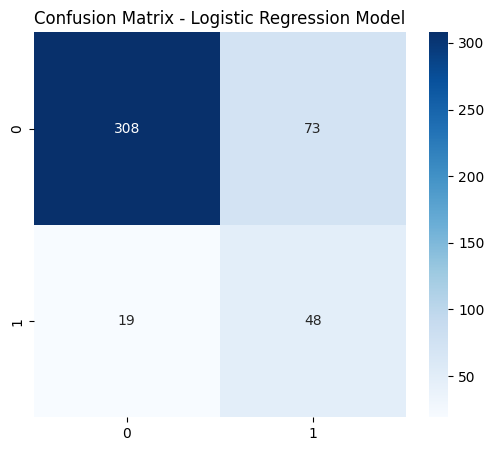

In [17]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression Model")
plt.show()

# Step 15: Feature Importance

Identifies the most important features in decision-making.



In [18]:
feature_importances_rf = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances_rf = feature_importances_rf.sort_values(ascending=False)

# Conclusion: Model Performance Overview

* Logistic Regression Accuracy: 79.46%
* Random Forest Accuracy: 87.05%
* Random Forest outperforms Logistic Regression in overall accuracy and class balance handling.
* Both models struggle with predicting "Responded" customers (Class 1).
* Logistic Regression has a high false positive rate, while Random Forest is more balanced.

# Campaign Response Prediction
* False negatives (missed responders) are still a challenge.
Logistic Regression: 19 false negatives (missed responders).
Random Forest: 33 false negatives (missed responders).
* Random Forest is slightly more reliable in predicting responders than Logistic Regression.
* Class imbalance remains an issue, despite using SMOTE to balance training data.
* Adjusting the classification threshold (lowering from 0.5 to ~0.3) could improve recall for responders.

# Feature Importance Insights
* Random Forest: Recency, Spending, and Marital Status are key predictors.
* Logistic Regression: NumStorePurchases, Recency, Web Activity, and Past Promo Acceptance influence response.
* Recency (how recent their last purchase was) is the strongest predictor in both models.
* Marital status & income appear in Random Forest but not in Logistic Regression, suggesting nonlinear interactions.
* Web engagement (NumWebVisitsMonth) plays a role in response likelihood.

# Retrospective: The Below is the Entire Code

<ipython-input-2-8c50b9854be4>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Income"].fillna(df["Income"].median(), inplace=True)


----- Results: Logistic Regression -------------------------------------
Logistic Regression Accuracy: 0.7946

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.81      0.87       381
           1       0.40      0.72      0.51        67

    accuracy                           0.79       448
   macro avg       0.67      0.76      0.69       448
weighted avg       0.86      0.79      0.82       448

----- Results: Random Forest ------------------------------------------
Random Forest Accuracy: 0.8705

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.92       381
           1       0.58      0.51      0.54        67

    accuracy                           0.87       448
   macro avg       0.75      0.72      0.73       448
weighted avg       0.86      0.87      0.87       448



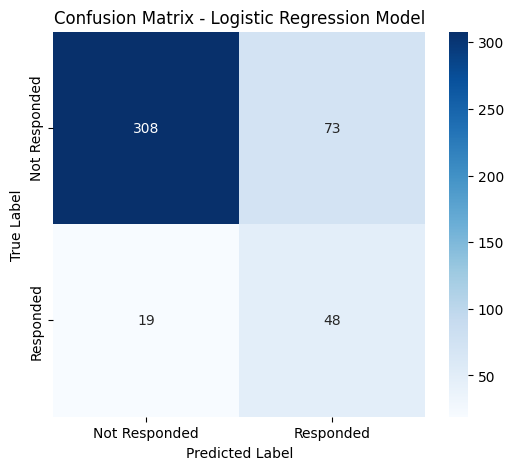

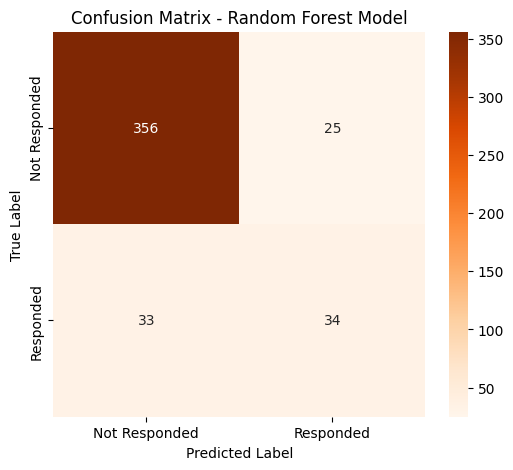

<ipython-input-2-8c50b9854be4>:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances_logreg[:10], y=feature_importances_logreg.index[:10], palette="viridis")


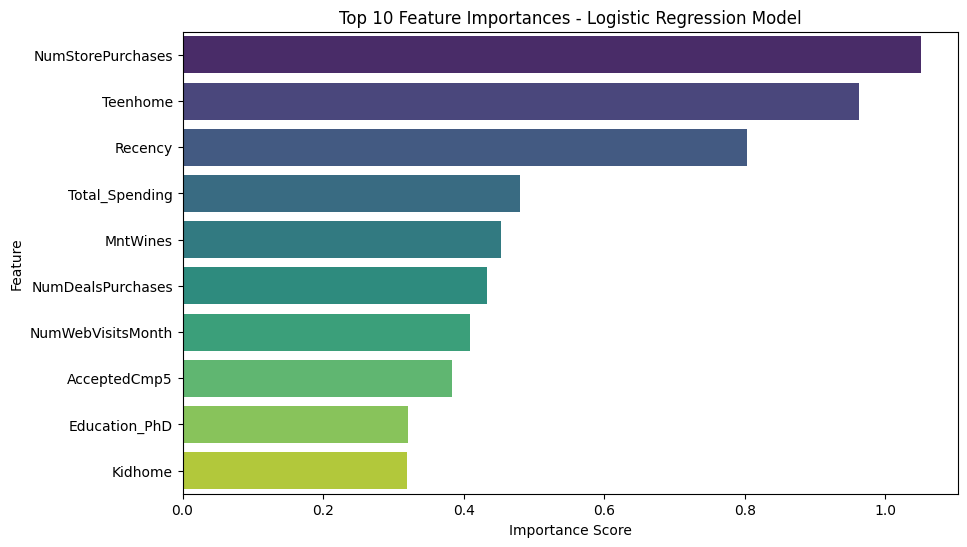

<ipython-input-2-8c50b9854be4>:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances_rf[:10], y=feature_importances_rf.index[:10], palette="coolwarm")


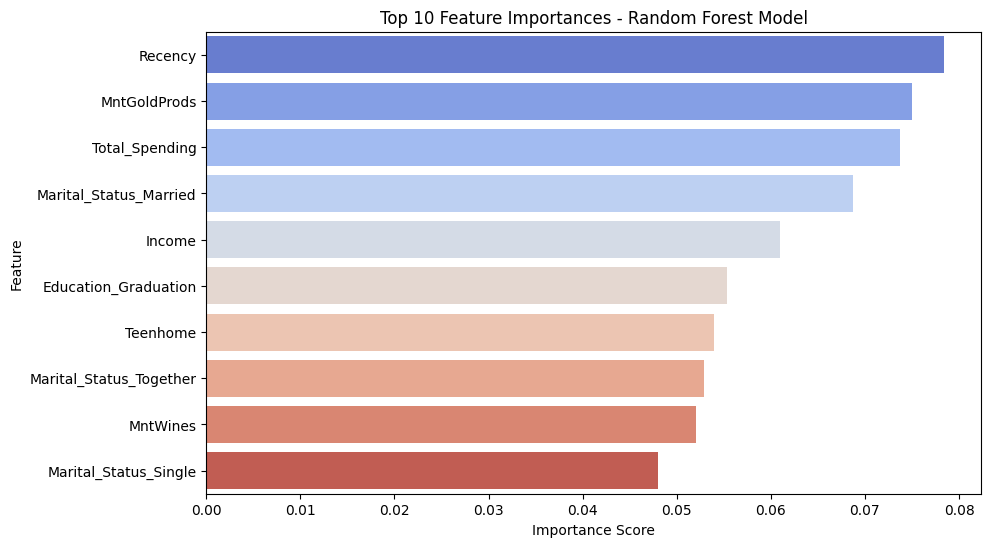

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

# Load dataset
url = "https://docs.google.com/spreadsheets/d/1ew-NKCxOwbRhSY2lIeO-XnxIb5tZrNCilixxu6y8ZnM/export?format=csv"
df = pd.read_csv(url)

# Fill missing values in 'Income' column with median.
df["Income"].fillna(df["Income"].median(), inplace=True)

# Create "Total_Spending" feature to sum spending over the last 2 years.
df["Total_Spending"] = (
    df["MntWines"] + df["MntFruits"] + df["MntMeatProducts"] +
    df["MntFishProducts"] + df["MntSweetProducts"] + df["MntGoldProds"]
)

# Categorize customers into 'High Value' or 'Budget' shoppers based on Total Spending.
median_spending = df["Total_Spending"].median()
df["Shopper_Type"] = np.where(df["Total_Spending"] >= median_spending, "High Value", "Budget")

# One-Hot Encoding for categorical features ('Education', 'Marital_Status', 'Shopper_Type').
encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_cats = encoder.fit_transform(df[["Education", "Marital_Status", "Shopper_Type"]])
encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out())

# Merge encoded features into dataframe & drop original categorical columns.
df = pd.concat([df.drop(columns=["Education", "Marital_Status", "Shopper_Type"]), encoded_df], axis=1)

# Fix 1: Remove "Marketing_Responsiveness" (Data Leakage Prevention)
if "Marketing_Responsiveness" in df.columns:
    df.drop(columns=["Marketing_Responsiveness"], inplace=True)

# Define Features (X) and Target (y).
X = df.drop(columns=["ID", "Response", "Dt_Customer"])  # Exclude non-relevant columns
y = df["Response"]  # Target variable

# Fix 2: Perform Train-Test Split Before Applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fix 3: Apply SMOTE Only on Training Data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Normalize numerical features using StandardScaler.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fix 4: Train Logistic Regression with Regularization
log_reg_model = LogisticRegression(max_iter=1000, C=0.1, random_state=42)
log_reg_model.fit(X_train, y_train)

# Fix 5: Train Random Forest with Constraints to Reduce Overfitting
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, max_features="sqrt", random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions.
y_pred_logreg = log_reg_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Evaluate Logistic Regression model.
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
classification_report_logreg = classification_report(y_test, y_pred_logreg)

# Evaluate Random Forest model.
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_report_rf = classification_report(y_test, y_pred_rf)

# Display Results.
print("----- Results: Logistic Regression -------------------------------------")
print(f"Logistic Regression Accuracy: {accuracy_logreg:.4f}")
print("\nClassification Report:\n", classification_report_logreg)

print("----- Results: Random Forest ------------------------------------------")
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print("\nClassification Report:\n", classification_report_rf)

# Compute confusion matrix for Logistic Regression.
cm_logreg = confusion_matrix(y_test, y_pred_logreg)

# Plot Confusion Matrix.
plt.figure(figsize=(6, 5))
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Responded", "Responded"], yticklabels=["Not Responded", "Responded"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression Model")
plt.show()

# Compute confusion matrix for Random Forest.
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Oranges", xticklabels=["Not Responded", "Responded"], yticklabels=["Not Responded", "Responded"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest Model")
plt.show()

# Feature Importance (Using Absolute Coefficients for Logistic Regression).
feature_importances_logreg = pd.Series(abs(log_reg_model.coef_.flatten()), index=X.columns)
feature_importances_logreg = feature_importances_logreg.sort_values(ascending=False)

# Plot Feature Importance.
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_logreg[:10], y=feature_importances_logreg.index[:10], palette="viridis")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances - Logistic Regression Model")
plt.show()

# Feature Importance (Using Feature Importances from Random Forest).
feature_importances_rf = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances_rf = feature_importances_rf.sort_values(ascending=False)

# Plot Feature Importance for Random Forest.
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_rf[:10], y=feature_importances_rf.index[:10], palette="coolwarm")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances - Random Forest Model")
plt.show()
